In [6]:
#We import libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d
import pandas as pd

In [2]:
#Keras is a high level neural networks library, based on either tensorflow or theano
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

C:\Users\vishv\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
INPUT_LIB = ''
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

In [14]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [15]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

In [16]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [17]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [18]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

In [19]:
#Then speed things up a little
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/40
 - 17s - loss: 0.6979 - acc: 0.5628 - val_loss: 0.5509 - val_acc: 0.8211
Epoch 2/40
 - 16s - loss: 0.6775 - acc: 0.5947 - val_loss: 0.5209 - val_acc: 0.8386
Epoch 3/40
 - 13s - loss: 0.6577 - acc: 0.6231 - val_loss: 0.5225 - val_acc: 0.8053
Epoch 4/40
 - 13s - loss: 0.6431 - acc: 0.6269 - val_loss: 0.5188 - val_acc: 0.8053
Epoch 5/40
 - 17s - loss: 0.6356 - acc: 0.6512 - val_loss: 0.5187 - val_acc: 0.8000
Epoch 6/40
 - 18s - loss: 0.6224 - acc: 0.6676 - val_loss: 0.5039 - val_acc: 0.8158
Epoch 7/40
 - 14s - loss: 0.6004 - acc: 0.6856 - val_loss: 0.4674 - val_acc: 0.8368
Epoch 8/40
 - 13s - loss: 0.5995 - acc: 0.6960 - val_loss: 0.4636 - val_acc: 0.8474
Epoch 9/40
 - 15s - loss: 0.6035 - acc: 0.6777 - val_loss: 0.4713 - val_acc: 0.8439
Epoch 10/40
 - 19s - loss: 0.5880 - acc: 0.6957 - val_loss: 0.4550 - val_acc: 0.8596
Epoch 11/40
 - 16s - loss: 0.5743 - acc: 0.6989 - val_loss: 0.4305 - val_acc: 0.8614
Epoch 12/40
 - 18s - loss: 0.5633 - acc: 0.7115 - val_loss: 0.4324 - val_a

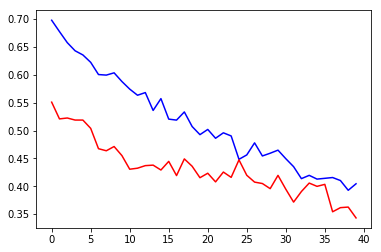

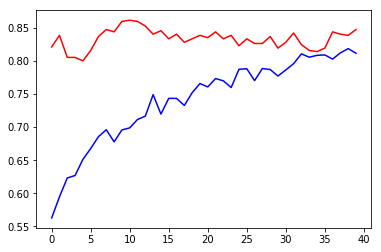

In [20]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [21]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

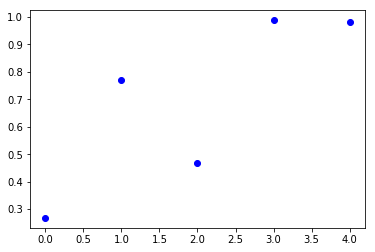

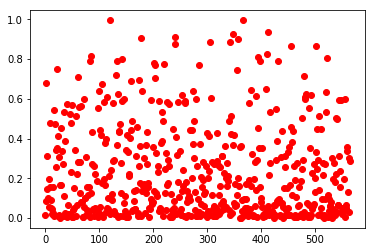

In [22]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

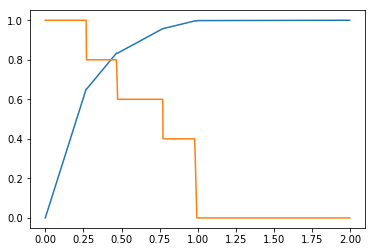

Crossover at 0.27 with specificity 0.65


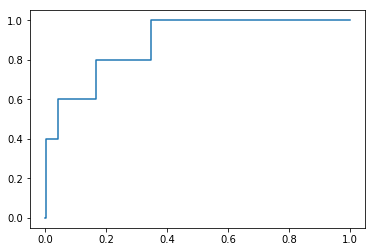

ROC area under curve is 0.89


In [23]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

7


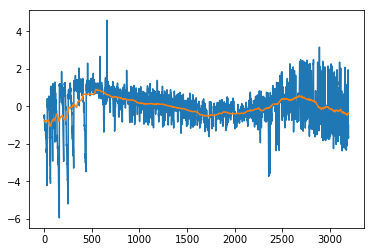

9


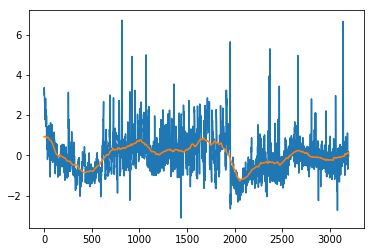

13


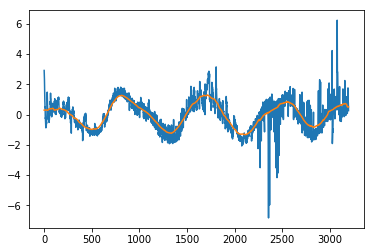

21


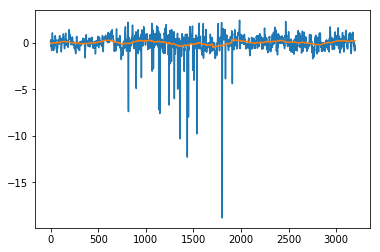

23


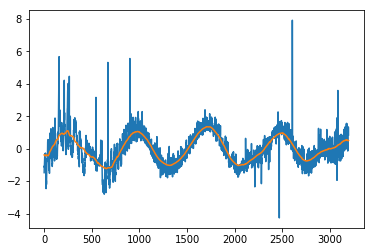

25


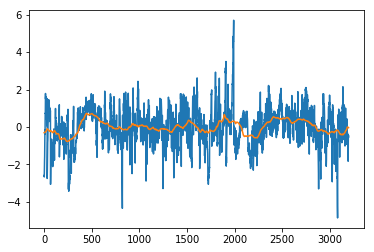

26


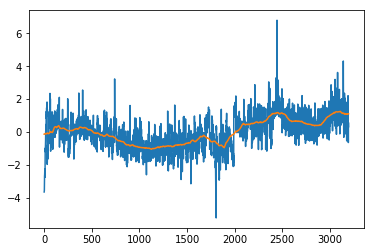

27


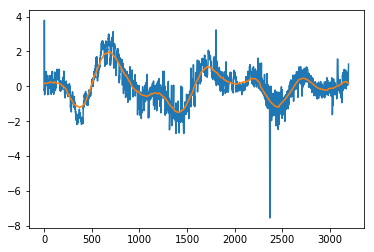

28


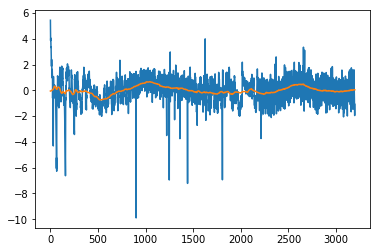

30


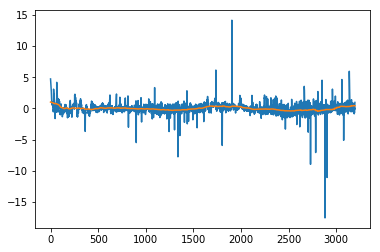

34


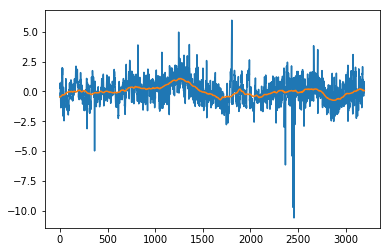

36


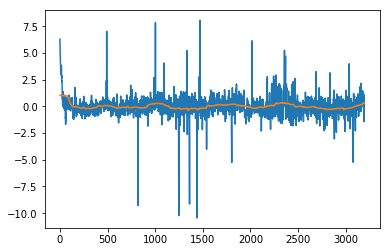

37


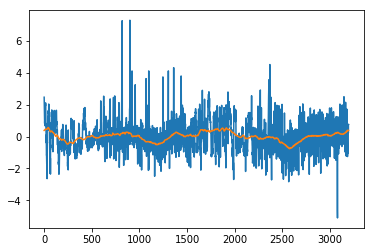

40


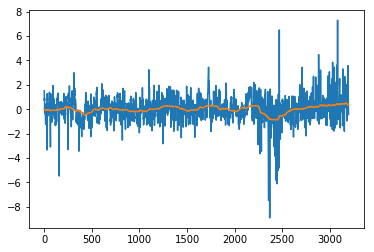

42


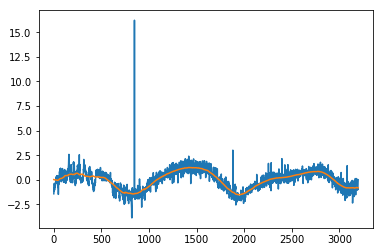

46


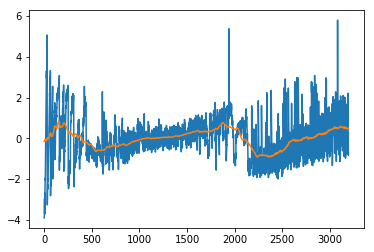

51


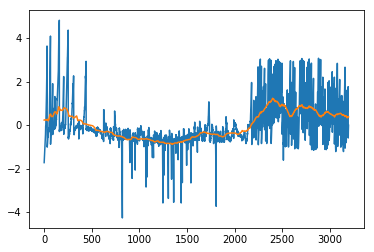

53


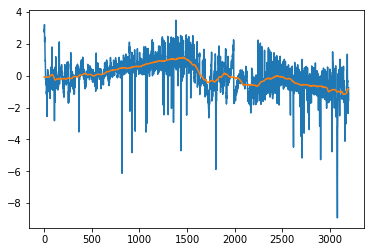

54


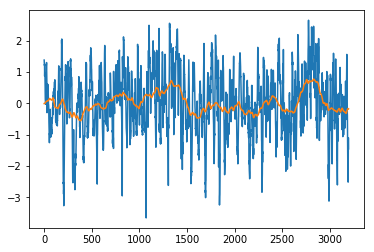

60


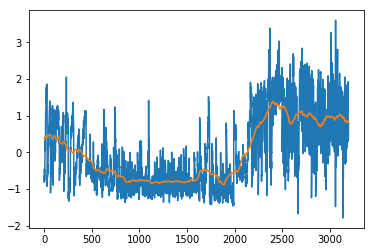

61


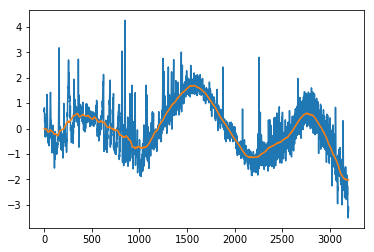

65


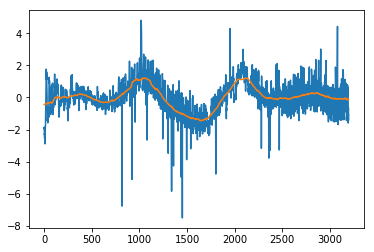

66


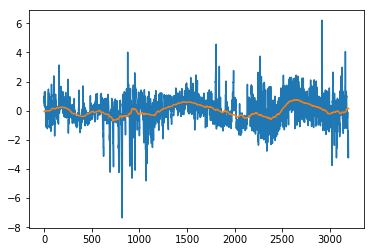

67


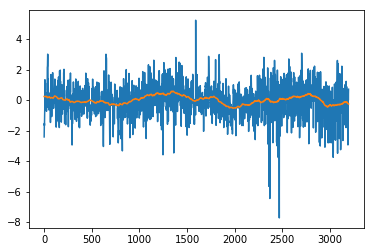

68


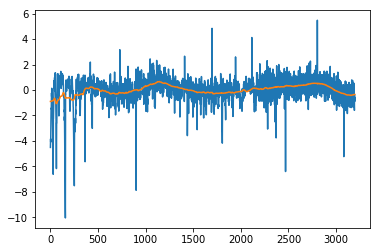

70


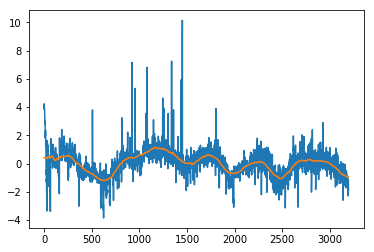

72


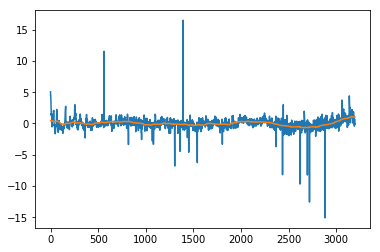

77


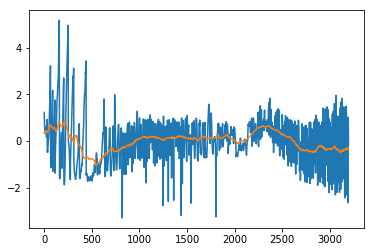

81


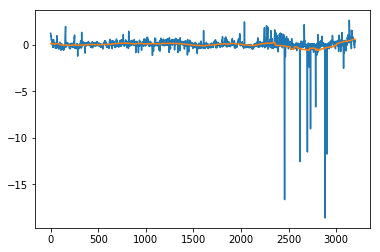

87


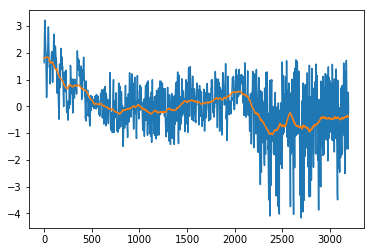

89


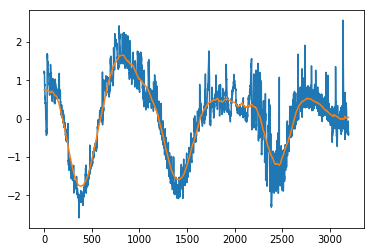

91


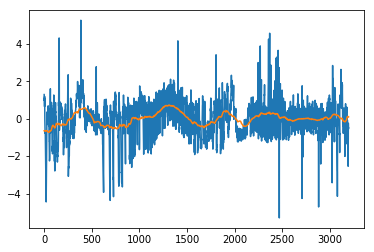

92


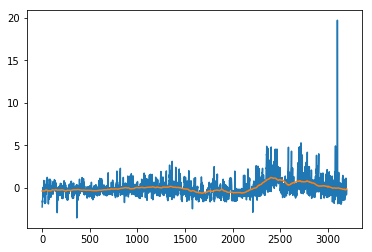

103


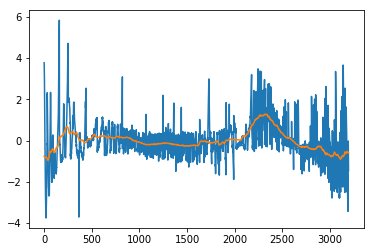

104


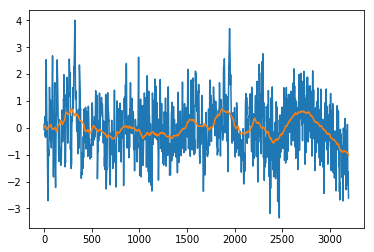

106


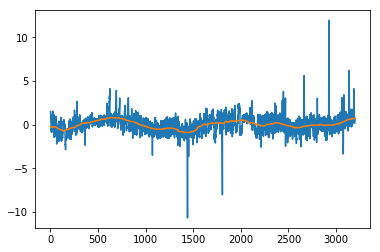

109


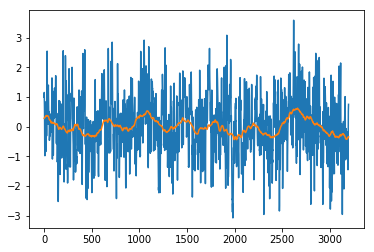

110


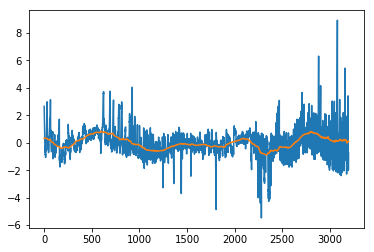

114


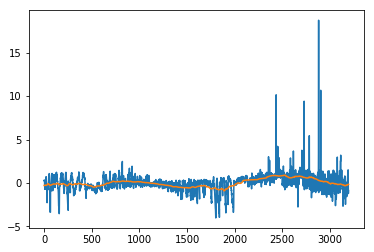

116


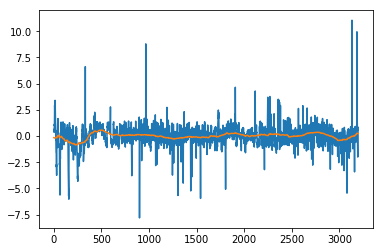

117


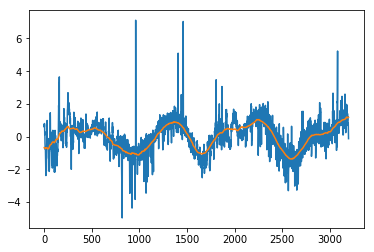

120


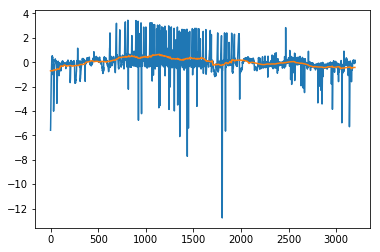

124


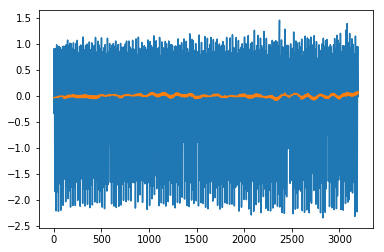

130


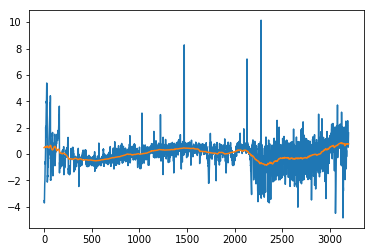

131


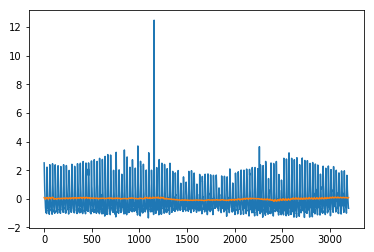

132


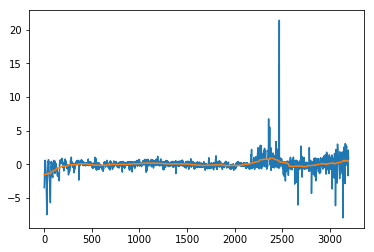

136


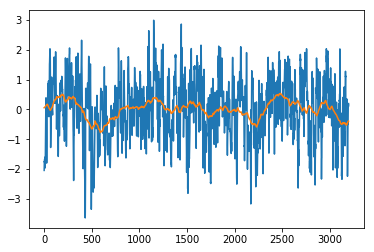

137


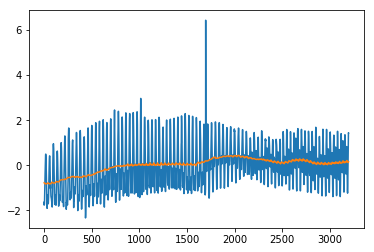

138


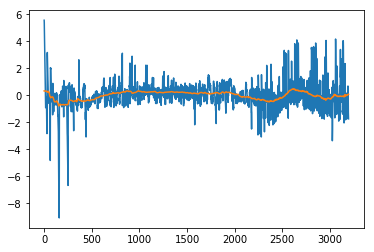

139


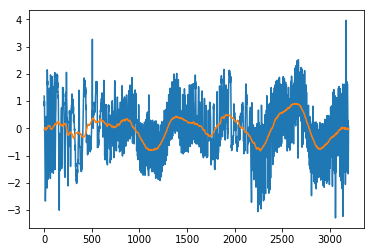

141


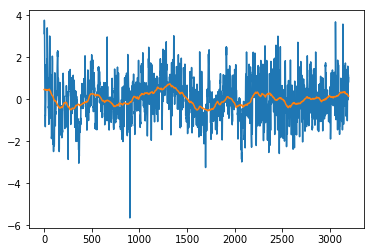

142


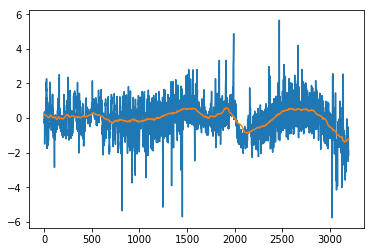

144


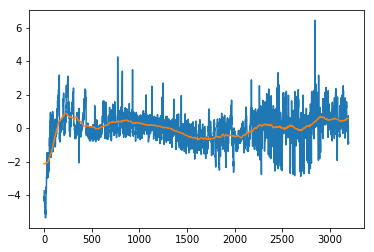

145


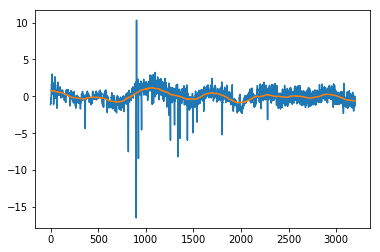

147


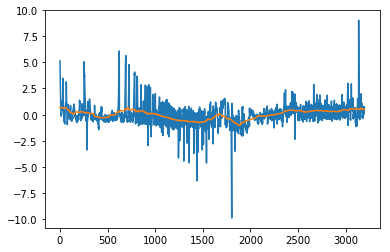

148


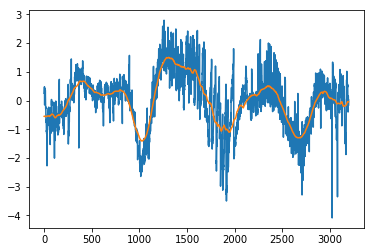

150


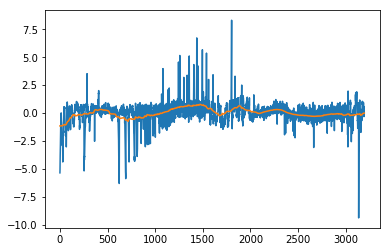

154


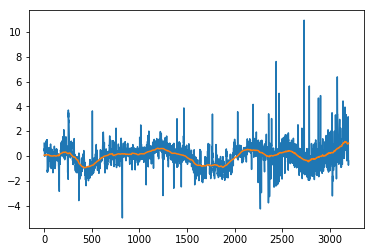

156


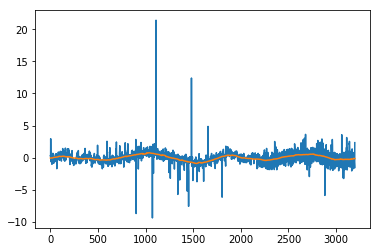

159


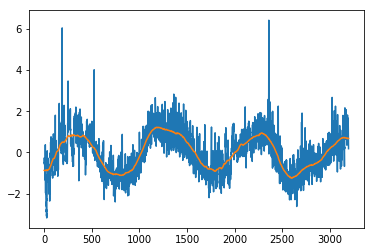

162


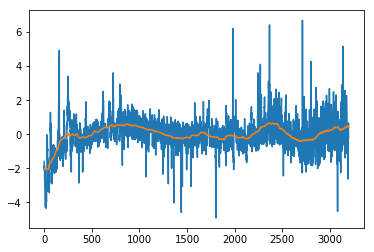

163


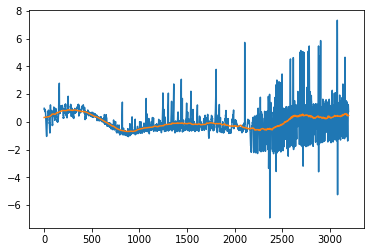

164


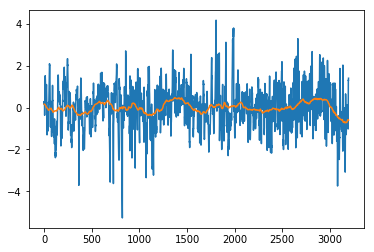

165


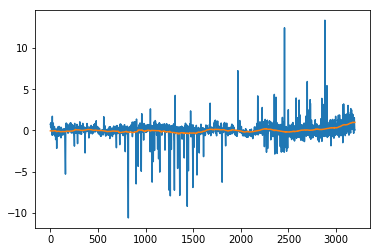

173


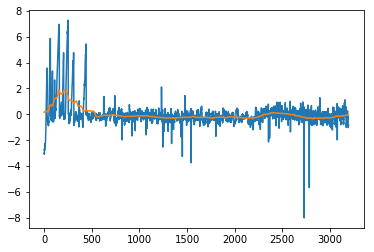

175


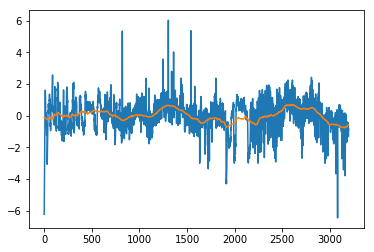

178


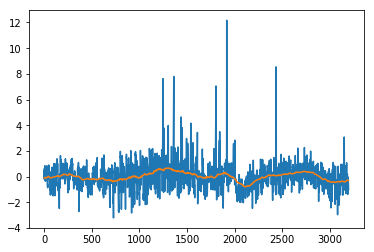

181


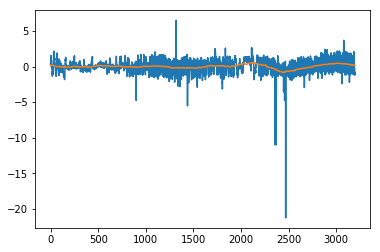

183


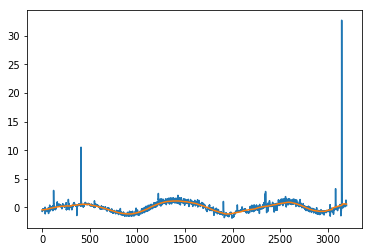

185


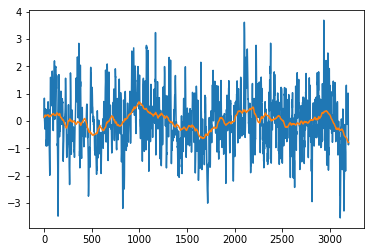

187


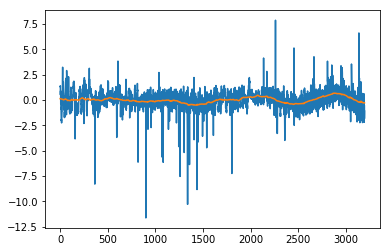

192


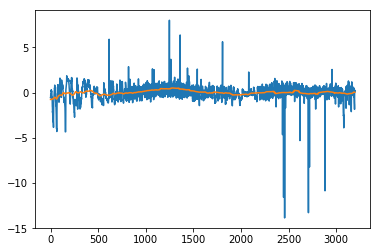

193


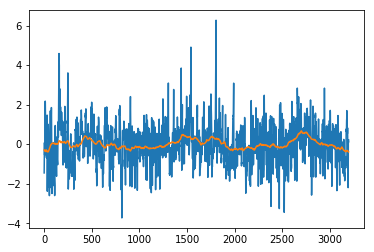

194


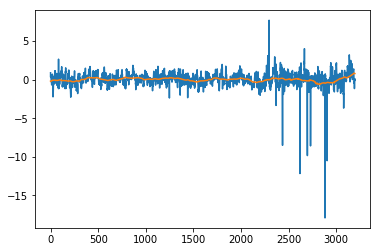

201


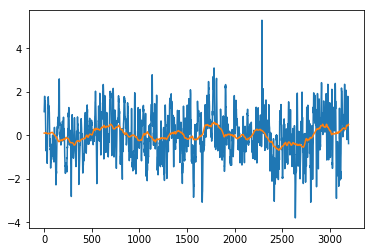

205


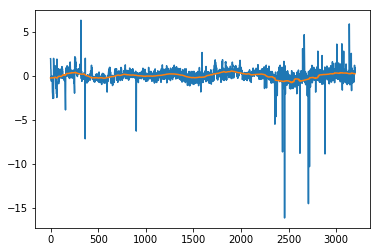

206


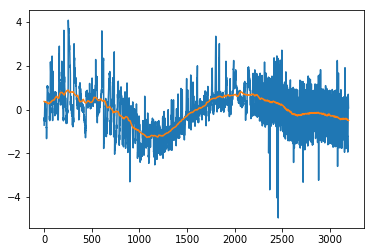

208


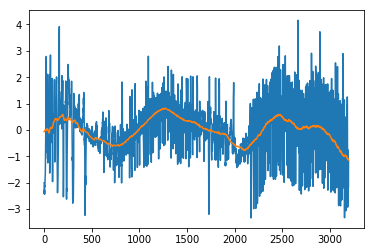

209


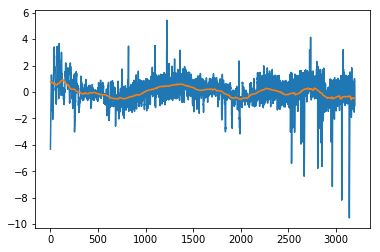

210


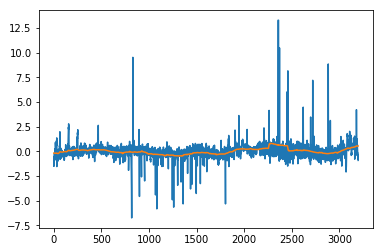

216


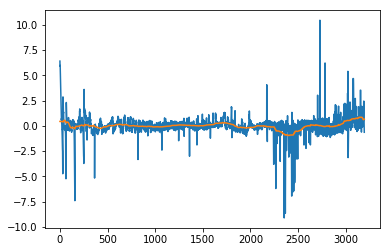

220


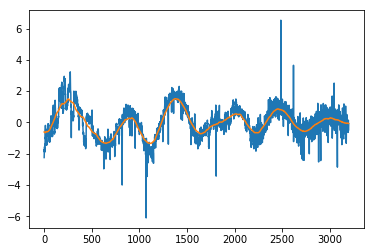

221


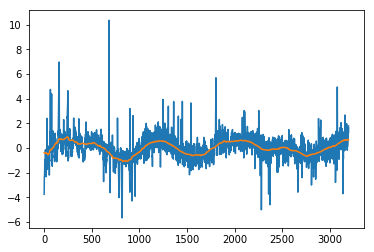

222


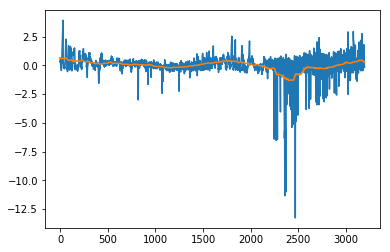

224


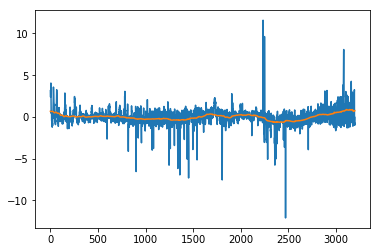

225


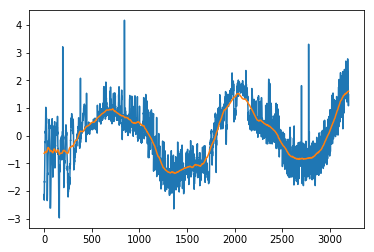

229


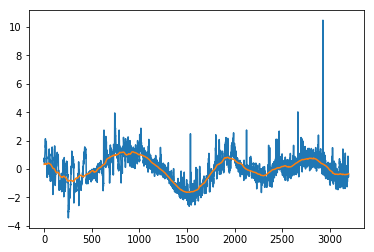

230


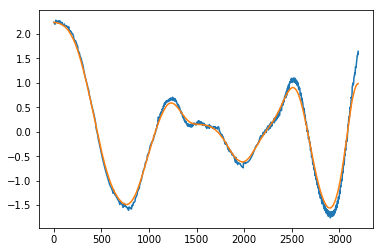

233


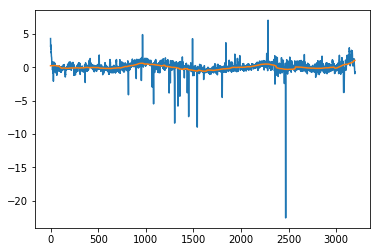

234


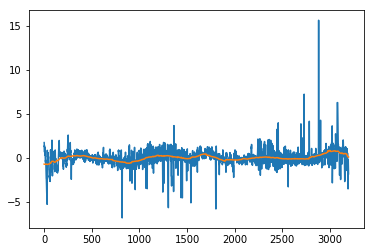

242


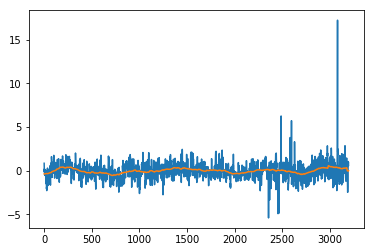

245


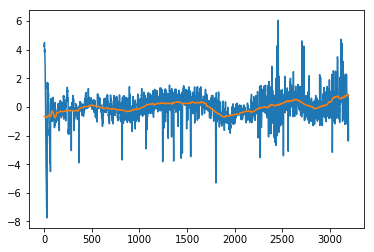

246


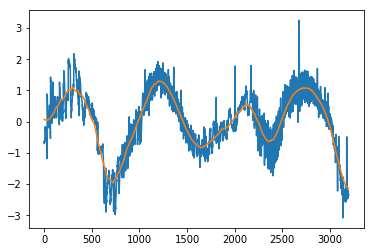

247


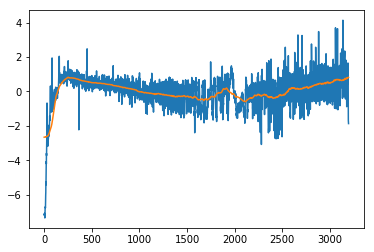

249


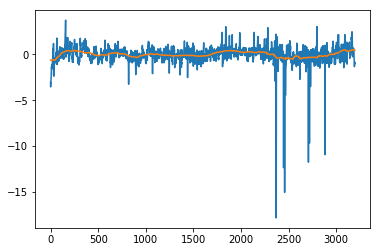

251


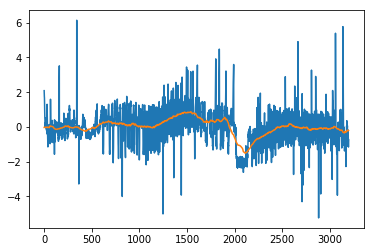

255


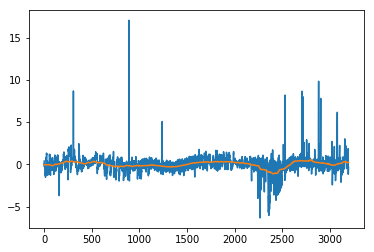

258


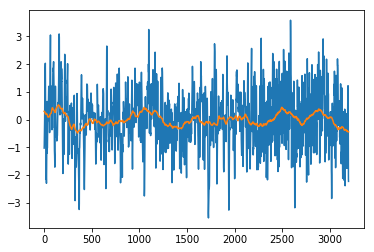

263


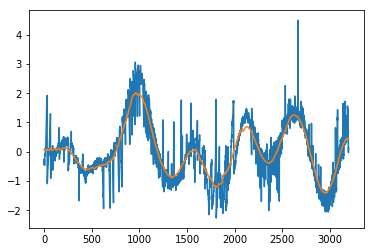

264


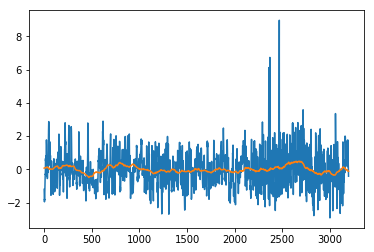

273


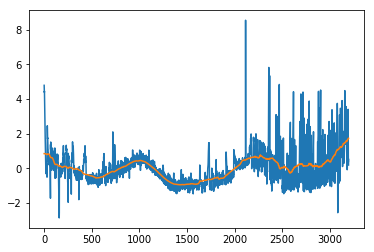

276


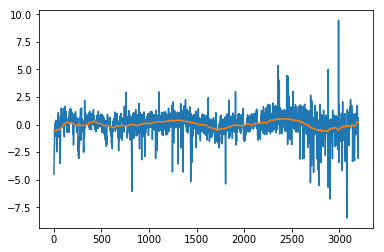

278


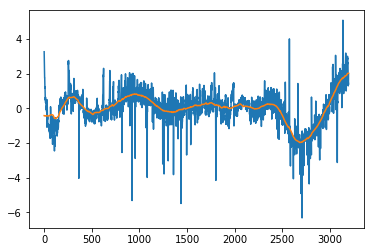

279


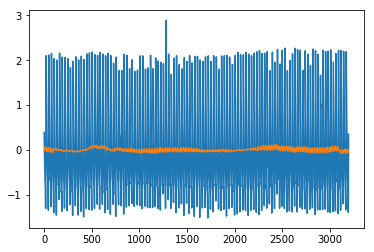

280


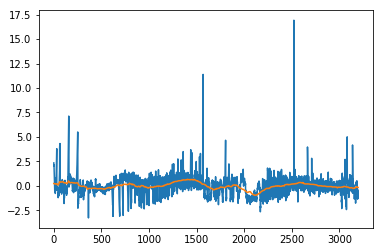

281


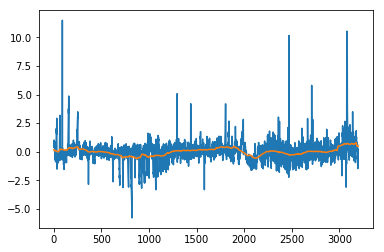

285


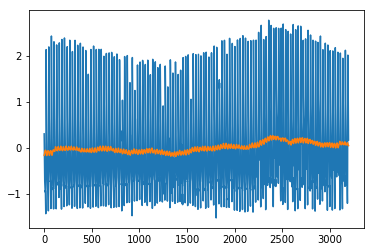

289


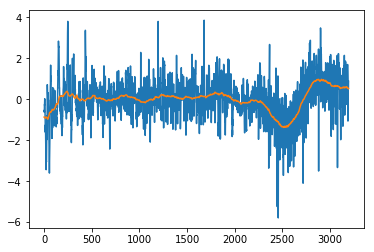

292


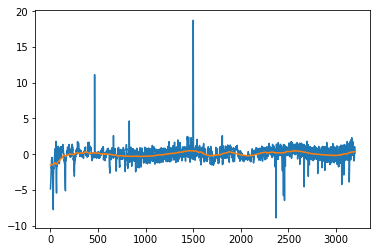

297


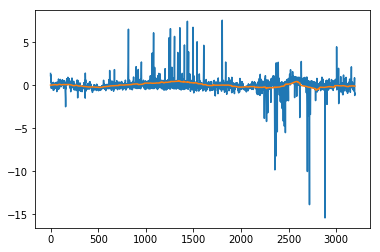

304


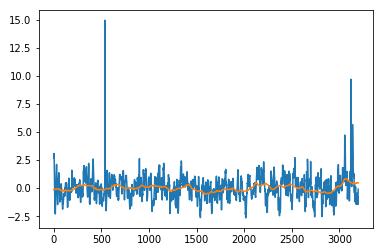

308


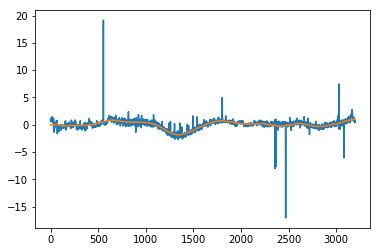

310


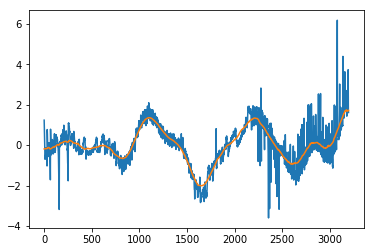

312


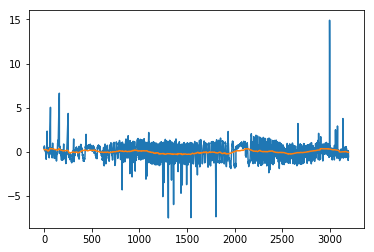

313


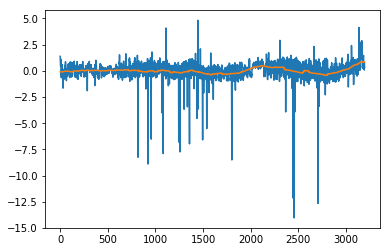

318


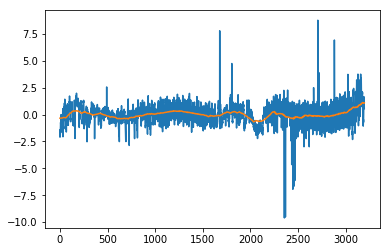

323


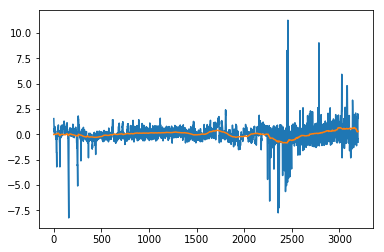

324


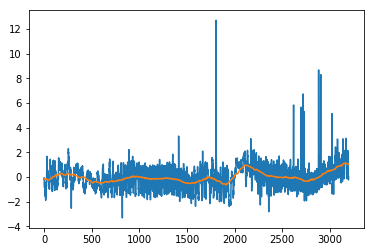

332


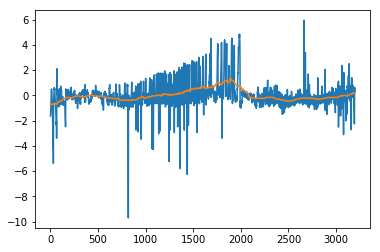

333


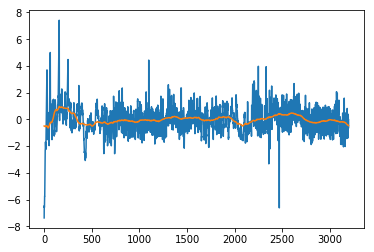

338


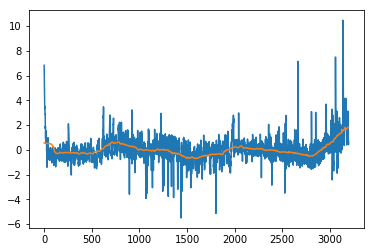

341


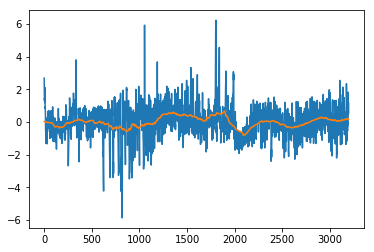

346


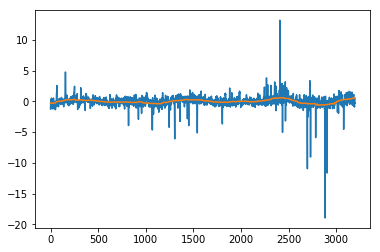

347


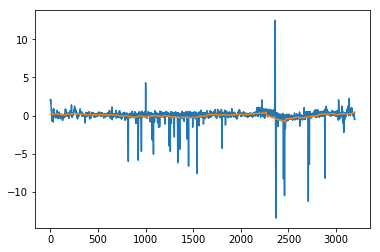

349


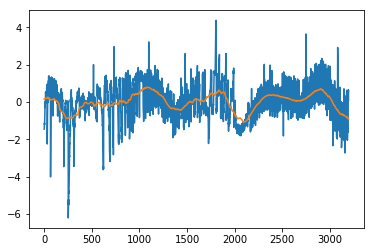

350


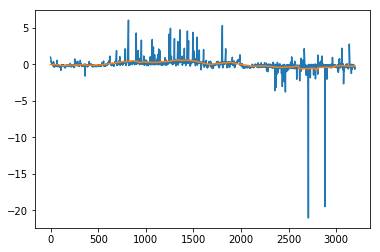

352


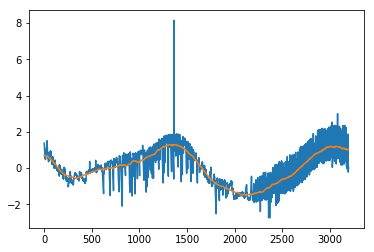

353


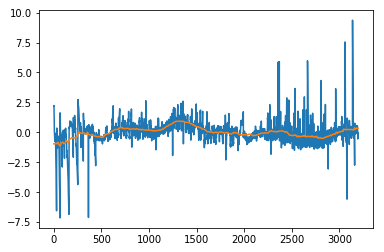

354


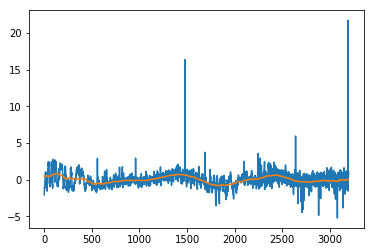

360


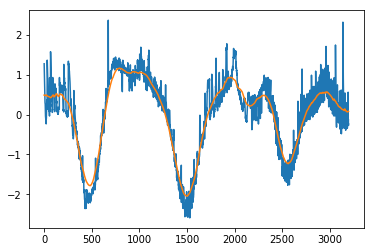

363


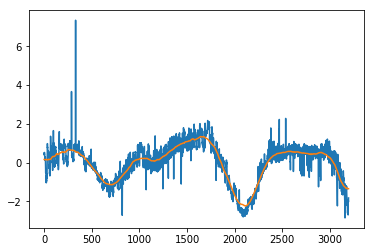

366


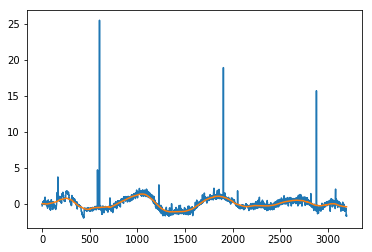

367


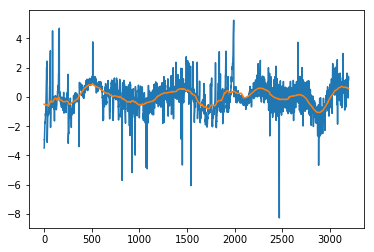

372


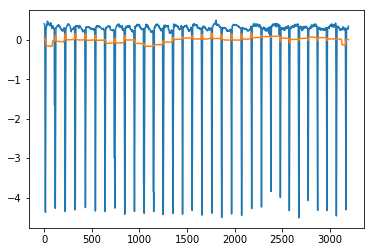

382


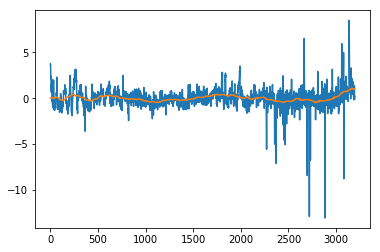

386


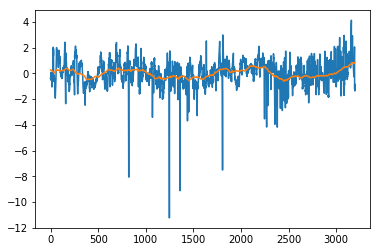

388


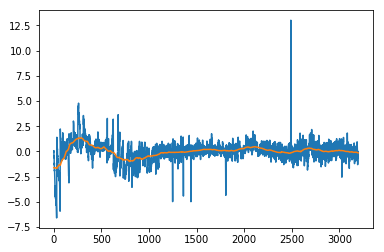

394


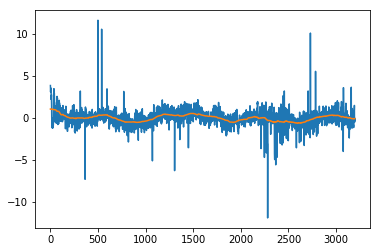

395


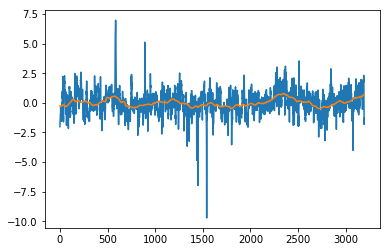

397


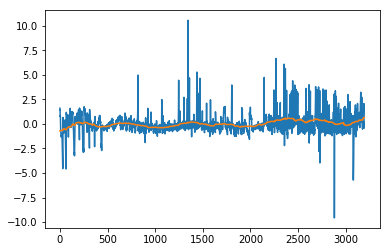

399


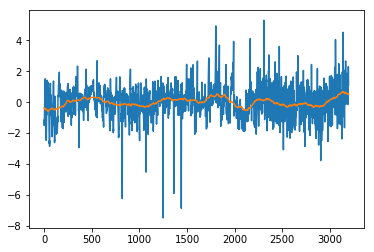

400


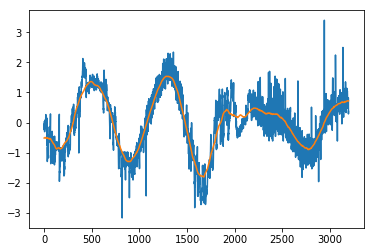

401


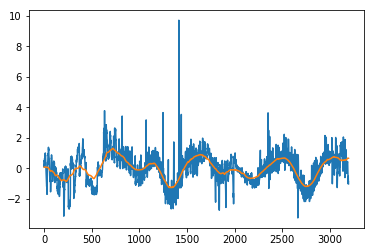

402


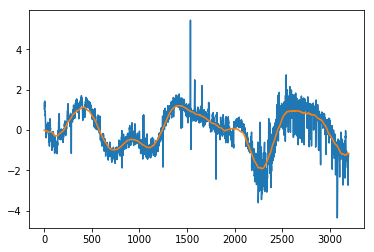

406


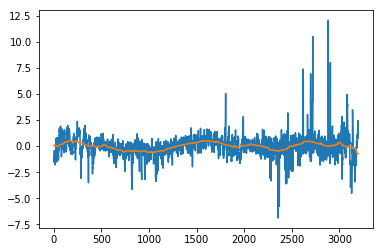

414


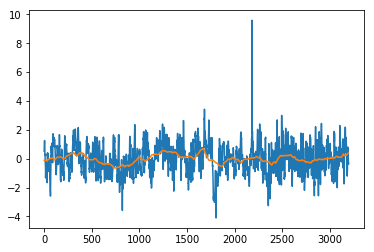

415


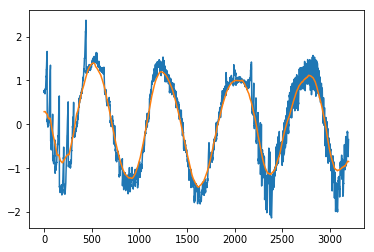

417


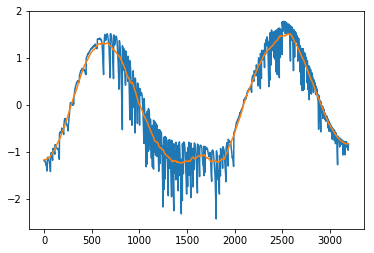

421


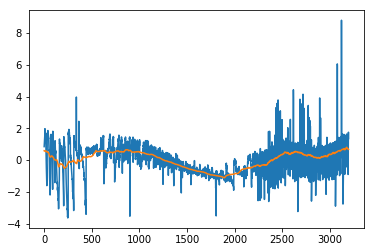

422


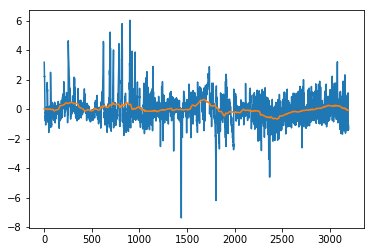

432


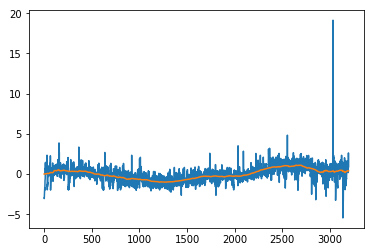

433


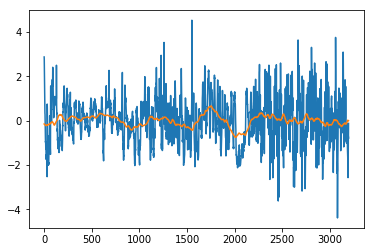

434


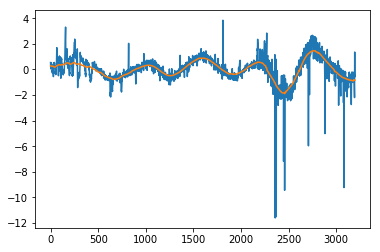

436


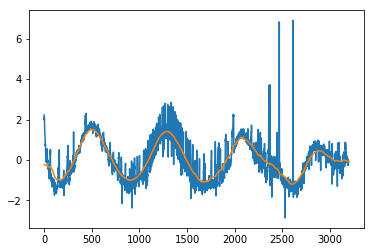

441


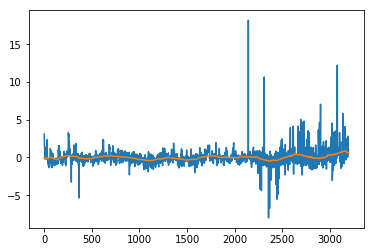

444


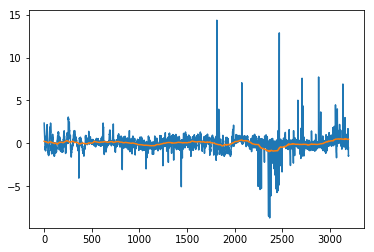

450


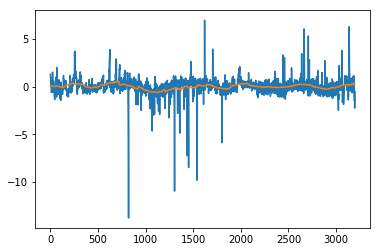

454


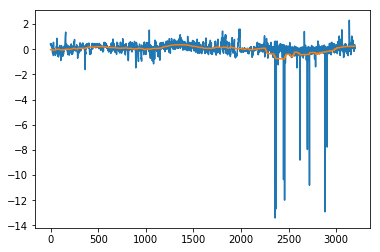

456


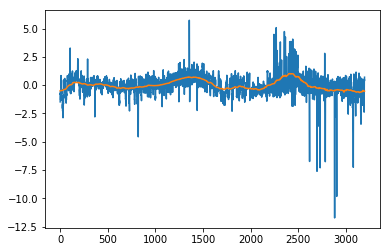

460


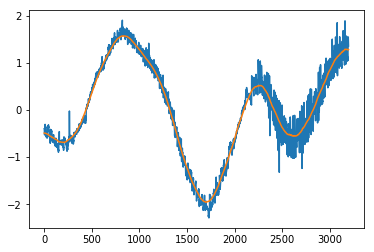

461


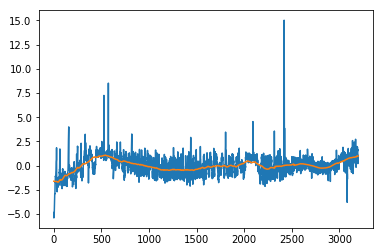

462


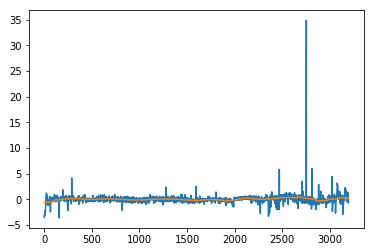

464


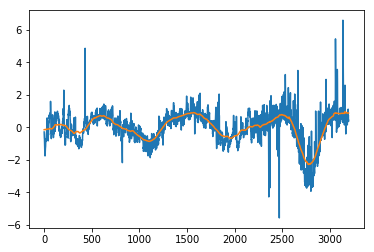

471


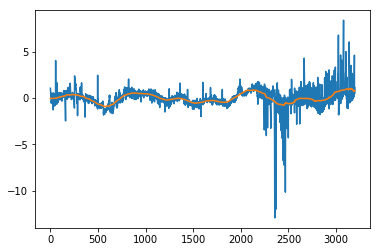

481


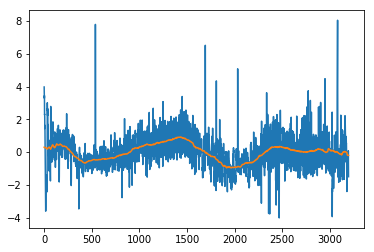

482


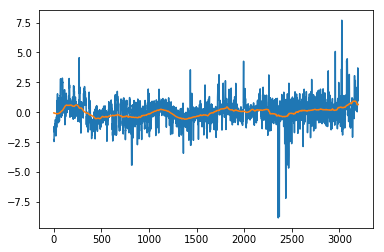

485


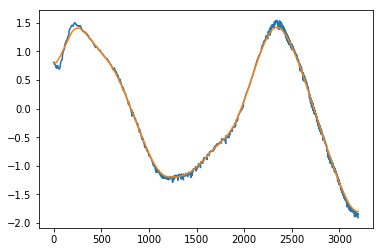

486


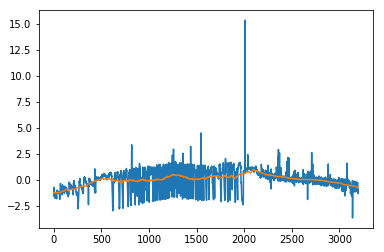

487


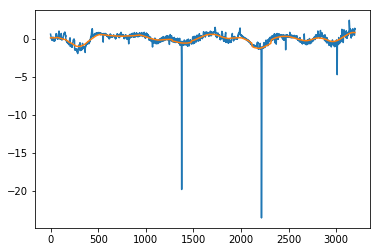

488


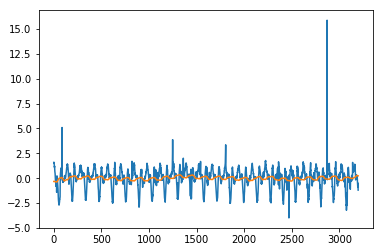

493


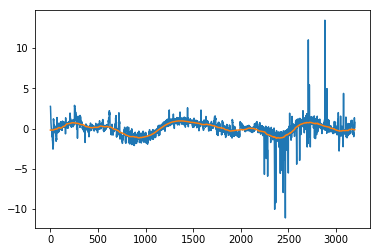

496


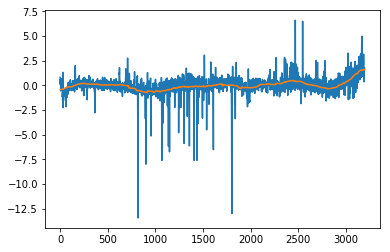

498


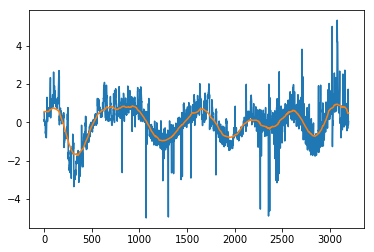

506


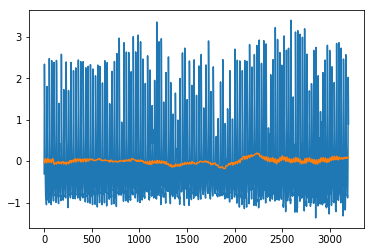

507


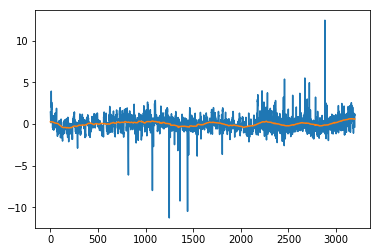

508


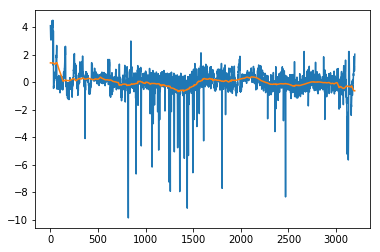

511


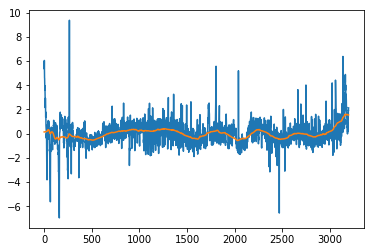

513


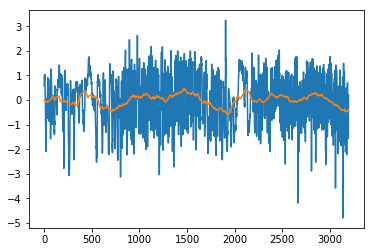

516


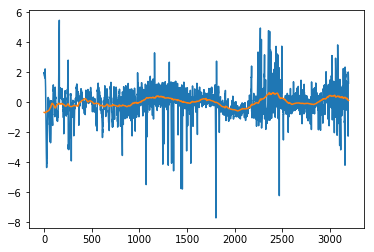

519


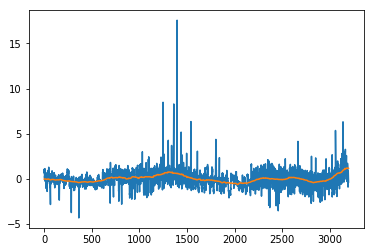

524


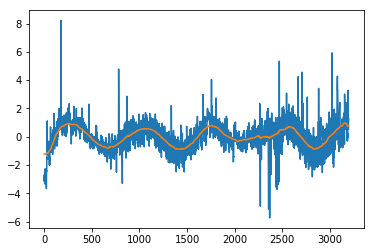

525


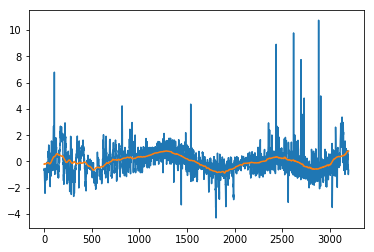

526


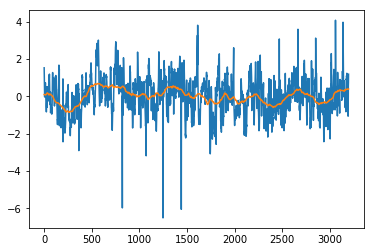

527


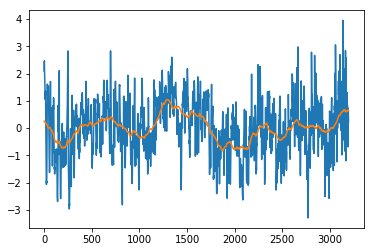

537


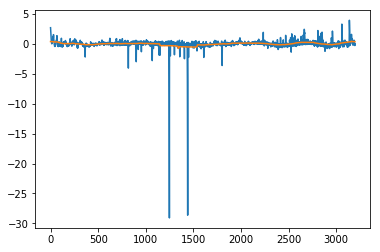

540


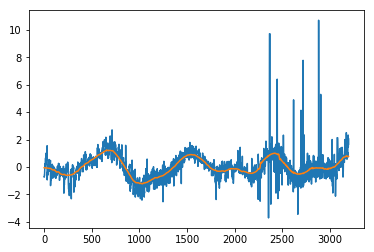

543


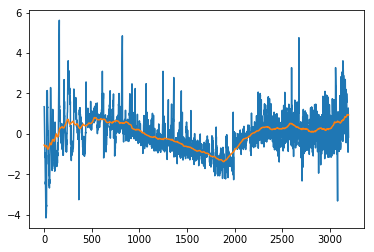

545


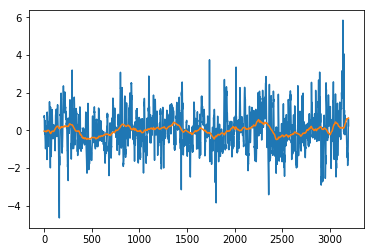

549


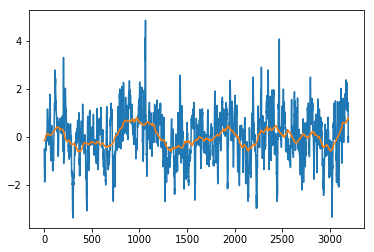

550


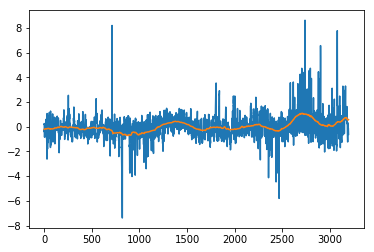

553


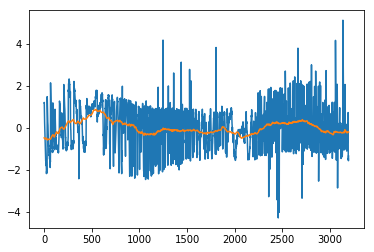

560


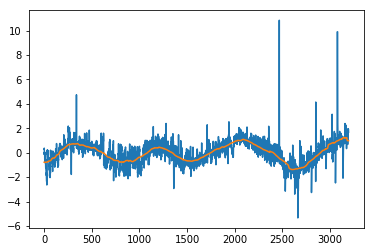

564


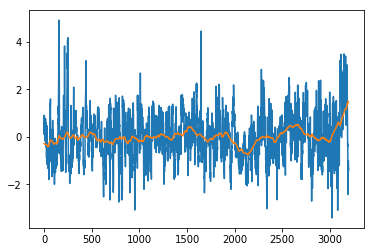

565


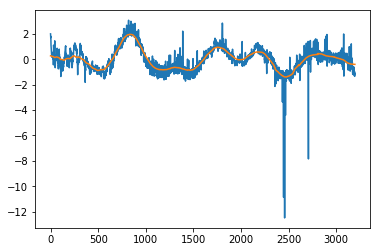

568


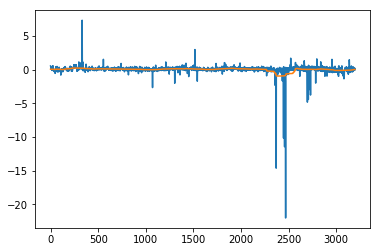

569


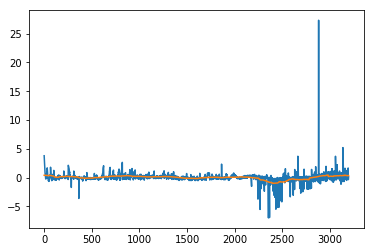

In [24]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

It seems that NASA has missed one planet. I am going to claim it and name it Pizza planet. 